# Essential Libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set plotting style

In [8]:
plt.style.use('default')
sns.set_palette("husl")

# 1. DATA LOADING AND CLEANING

In [9]:
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/online_retail_II.xlsx", engine='openpyxl')

print("Dataset Info:")
print(f"Shape: {df.shape}")
print(f"Missing Customer IDs: {df['Customer ID'].isnull().sum()}")

Dataset Info:
Shape: (525461, 8)
Missing Customer IDs: 107927


# Data cleaning function

In [10]:
def clean_data(df):
    """Clean and prepare retail transaction data"""
    print(f"Original shape: {df.shape}")

    # Remove missing Customer IDs and invalid quantities/prices
    df = df.dropna(subset=['Customer ID'])
    df = df[df['Quantity'] > 0]
    df = df[df['Price'] > 0]

    # Remove cancelled orders
    df = df[~df['Invoice'].astype(str).str.startswith('C')]

    # Create total price and ensure datetime
    df['TotalPrice'] = df['Quantity'] * df['Price']
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

    print(f"Cleaned shape: {df.shape}")
    return df

df_clean = clean_data(df)

Original shape: (525461, 8)
Cleaned shape: (407664, 9)


# 2. EXPLORATORY DATA ANALYSIS WITH ADDITIONAL VISUALIZATIONS

In [11]:
def comprehensive_eda(df):
    """Enhanced EDA with multiple business-focused visualizations"""

    plt.figure(figsize=(20, 12))

    # 1. Top Countries by Transaction Volume
    plt.subplot(2, 4, 1)
    top_countries = df['Country'].value_counts().head(10)
    sns.barplot(y=top_countries.index, x=top_countries.values, palette='viridis')
    plt.title('Top 10 Countries by Transactions', fontweight='bold')
    plt.xlabel('Number of Transactions')

    # 2. Revenue Distribution by Country
    plt.subplot(2, 4, 2)
    country_revenue = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)
    sns.barplot(y=country_revenue.index, x=country_revenue.values, palette='plasma')
    plt.title('Top 10 Countries by Revenue', fontweight='bold')
    plt.xlabel('Total Revenue')

    # 3. Monthly Sales Trend
    plt.subplot(2, 4, 3)
    df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')
    monthly_sales = df.groupby('YearMonth')['TotalPrice'].sum()
    monthly_sales.index = monthly_sales.index.to_timestamp()
    plt.plot(monthly_sales.index, monthly_sales.values, marker='o', linewidth=2)
    plt.title('Monthly Sales Trend', fontweight='bold')
    plt.xticks(rotation=45)

    # 4. Transaction Value Distribution
    plt.subplot(2, 4, 4)
    plt.hist(df['TotalPrice'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Transaction Value Distribution', fontweight='bold')
    plt.xlabel('Transaction Value')
    plt.yscale('log')

    # 5. Customer Transaction Frequency
    plt.subplot(2, 4, 5)
    customer_freq = df.groupby('Customer ID').size()
    plt.hist(customer_freq, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
    plt.title('Customer Transaction Frequency', fontweight='bold')
    plt.xlabel('Transactions per Customer')
    plt.yscale('log')

    # 6. Average Order Value Distribution
    plt.subplot(2, 4, 6)
    avg_order_value = df.groupby('Customer ID')['TotalPrice'].mean()
    plt.hist(avg_order_value, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
    plt.title('Average Order Value Distribution', fontweight='bold')
    plt.xlabel('Average Order Value')
    plt.yscale('log')

    # 7. Top Products by Quantity
    plt.subplot(2, 4, 7)
    top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
    plt.barh(range(len(top_products)), top_products.values, color='orange')
    plt.yticks(range(len(top_products)), [desc[:30] + '...' if len(desc) > 30 else desc for desc in top_products.index])
    plt.title('Top 10 Products by Quantity', fontweight='bold')

    # 8. Customer Value vs Frequency Scatter
    plt.subplot(2, 4, 8)
    customer_stats = df.groupby('Customer ID').agg({
        'TotalPrice': 'sum',
        'Invoice': 'nunique'
    })
    plt.scatter(customer_stats['Invoice'], customer_stats['TotalPrice'], alpha=0.6, color='purple')
    plt.xlabel('Transaction Frequency')
    plt.ylabel('Total Customer Value')
    plt.title('Customer Value vs Frequency', fontweight='bold')
    plt.yscale('log')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\n" + "="*50)
    print("DATASET SUMMARY")
    print("="*50)
    print(f"Total Customers: {df['Customer ID'].nunique():,}")
    print(f"Total Transactions: {len(df):,}")
    print(f"Total Revenue: ${df['TotalPrice'].sum():,.2f}")
    print(f"Average Order Value: ${df['TotalPrice'].mean():.2f}")
    print(f"Date Range: {df['InvoiceDate'].min()} to {df['InvoiceDate'].max()}")
    print(f"Number of Countries: {df['Country'].nunique()}")

# Run EDA

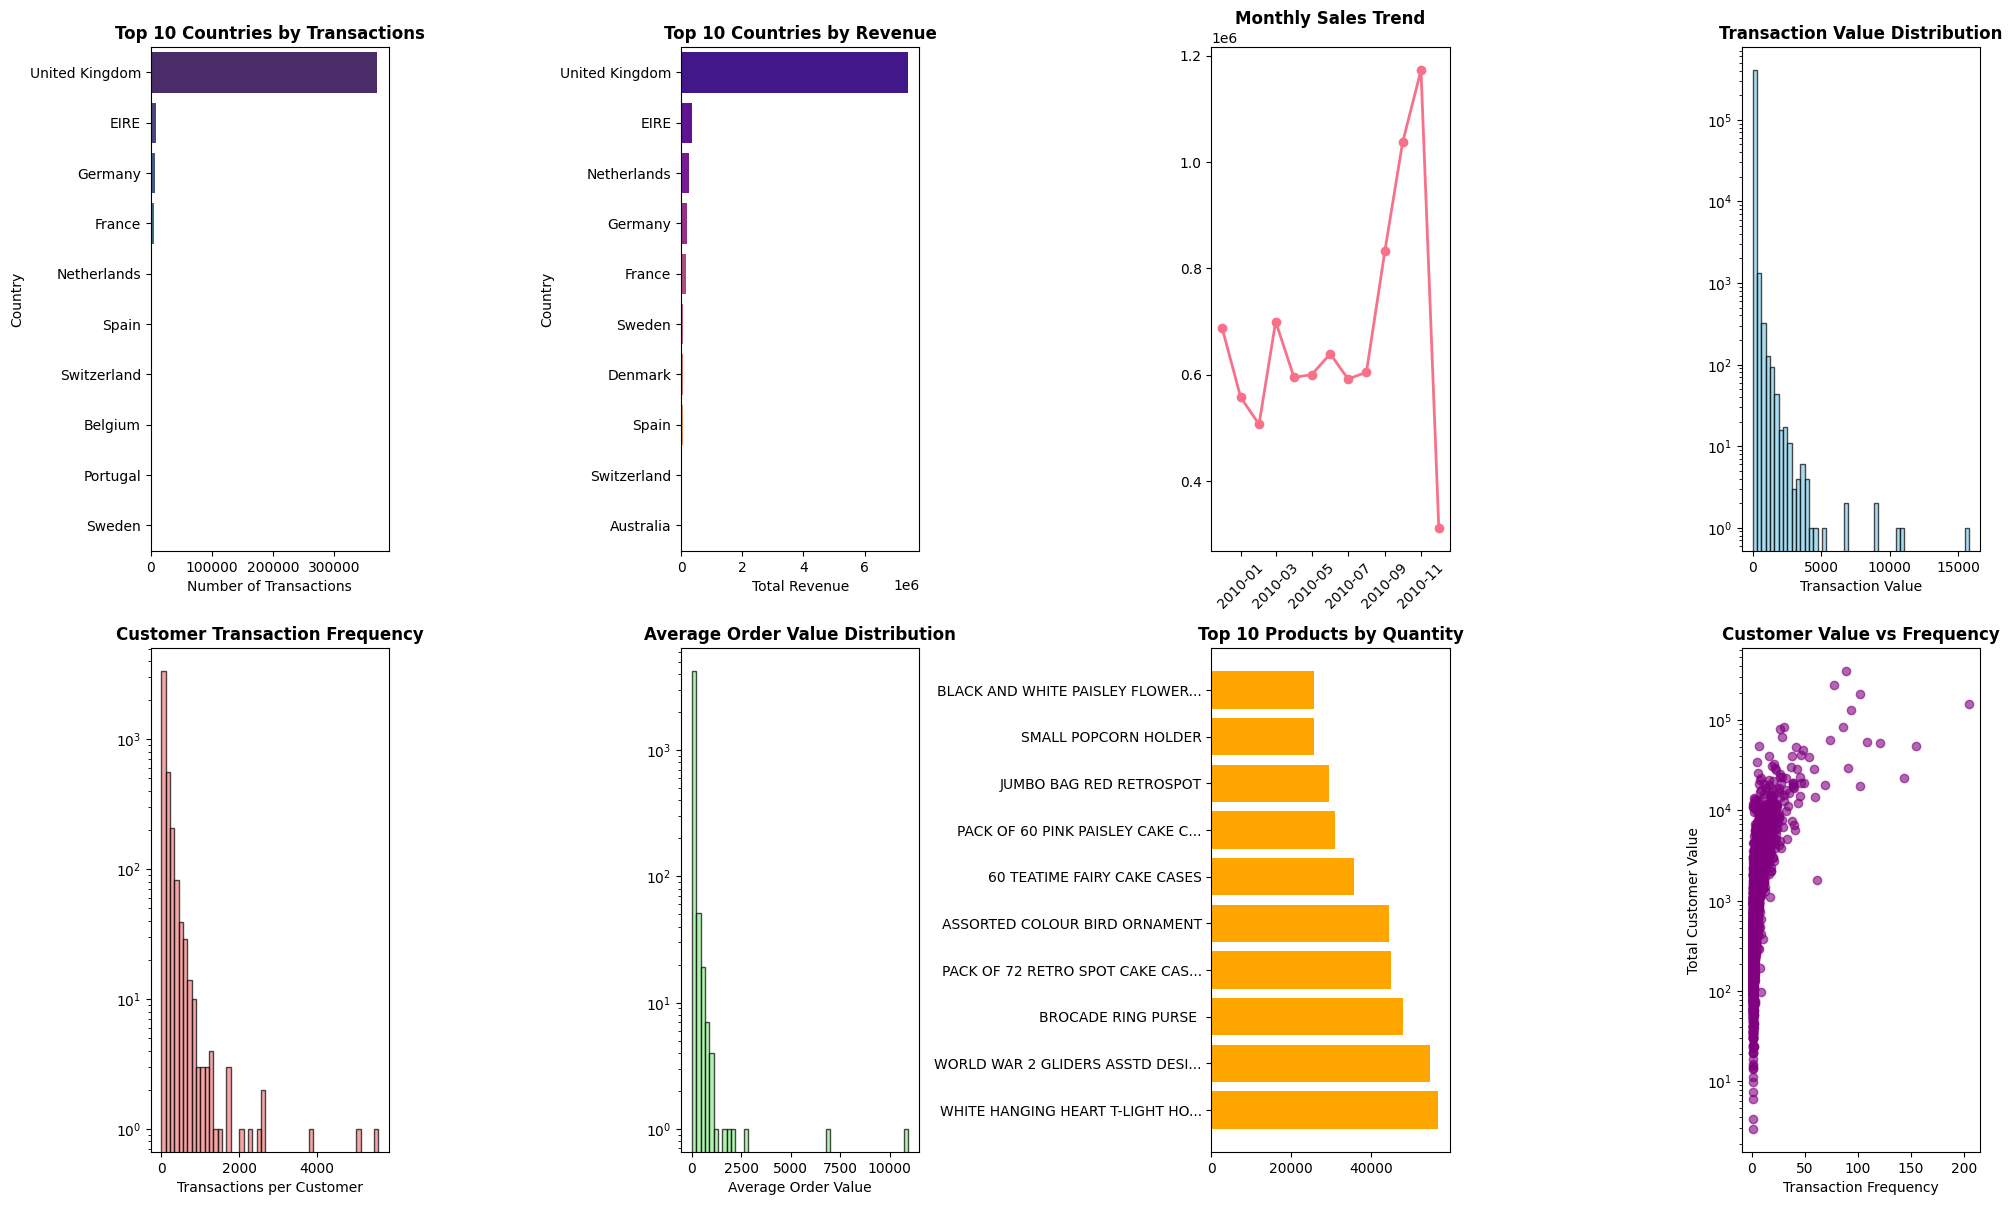


DATASET SUMMARY
Total Customers: 4,312
Total Transactions: 407,664
Total Revenue: $8,832,003.27
Average Order Value: $21.66
Date Range: 2009-12-01 07:45:00 to 2010-12-09 20:01:00
Number of Countries: 37


In [12]:
comprehensive_eda(df_clean)

# 3. RFM FEATURE ENGINEERING (Demographics + Purchase History) - FIXED

In [13]:
def calculate_rfm_features(df):
    """Calculate RFM metrics with demographic features - FIXED VERSION"""

    snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

    # Basic RFM calculation
    rfm = df.groupby('Customer ID').agg({
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
        'Invoice': 'nunique',  # Frequency
        'TotalPrice': ['sum', 'mean', 'std'],  # Monetary metrics
        'Quantity': ['sum', 'mean'],  # Volume metrics
        'Country': 'first'  # Demographics
    }).reset_index()

    # Flatten column names
    rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'MonetaryTotal',
                   'MonetaryMean', 'MonetaryStd', 'QuantityTotal', 'QuantityMean', 'Country']

    # Handle missing values
    rfm['MonetaryStd'] = rfm['MonetaryStd'].fillna(0)

    # Create additional features
    rfm['DaysActive'] = df.groupby('Customer ID')['InvoiceDate'].apply(
        lambda x: (x.max() - x.min()).days
    ).values
    rfm['AvgDaysBetweenOrders'] = rfm['DaysActive'] / (rfm['Frequency'] - 1)
    rfm['AvgDaysBetweenOrders'] = rfm['AvgDaysBetweenOrders'].fillna(0)

    # Country encoding (top countries, others as 'Other') - FIXED
    top_countries = df['Country'].value_counts().head(5).index
    rfm['Country_Encoded'] = rfm['Country'].apply(lambda x: x if x in top_countries else 'Other')

    # Create dummy variables for countries
    country_dummies = pd.get_dummies(rfm['Country_Encoded'], prefix='Country')
    rfm = pd.concat([rfm, country_dummies], axis=1)

    # Log transformations for better model performance
    rfm['Recency_log'] = np.log1p(rfm['Recency'])
    rfm['Frequency_log'] = np.log1p(rfm['Frequency'])
    rfm['MonetaryTotal_log'] = np.log1p(rfm['MonetaryTotal'])

    # Remove the original categorical columns to avoid confusion
    rfm = rfm.drop(['Country', 'Country_Encoded'], axis=1)

    return rfm

rfm_data = calculate_rfm_features(df_clean)
print(f"RFM Data Shape: {rfm_data.shape}")
print(f"Features: {rfm_data.columns.tolist()}")

RFM Data Shape: (4312, 19)
Features: ['CustomerID', 'Recency', 'Frequency', 'MonetaryTotal', 'MonetaryMean', 'MonetaryStd', 'QuantityTotal', 'QuantityMean', 'DaysActive', 'AvgDaysBetweenOrders', 'Country_EIRE', 'Country_France', 'Country_Germany', 'Country_Netherlands', 'Country_Other', 'Country_United Kingdom', 'Recency_log', 'Frequency_log', 'MonetaryTotal_log']


# Check for any non-numeric columns

In [14]:
print("\nData types check:")
print(rfm_data.dtypes)


Data types check:
CustomerID                float64
Recency                     int64
Frequency                   int64
MonetaryTotal             float64
MonetaryMean              float64
MonetaryStd               float64
QuantityTotal               int64
QuantityMean              float64
DaysActive                  int64
AvgDaysBetweenOrders      float64
Country_EIRE                 bool
Country_France               bool
Country_Germany              bool
Country_Netherlands          bool
Country_Other                bool
Country_United Kingdom       bool
Recency_log               float64
Frequency_log             float64
MonetaryTotal_log         float64
dtype: object


# 4. RFM ANALYSIS VISUALIZATIONS

In [15]:
def visualize_rfm_analysis(rfm):
    """Create comprehensive RFM visualizations"""

    plt.figure(figsize=(18, 12))

    # 1-3. RFM Distributions
    plt.subplot(2, 4, 1)
    plt.hist(rfm['Recency'], bins=50, alpha=0.7, color='red', edgecolor='black')
    plt.title('Recency Distribution (Days)', fontweight='bold')
    plt.xlabel('Days Since Last Purchase')

    plt.subplot(2, 4, 2)
    plt.hist(rfm['Frequency'], bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.title('Frequency Distribution', fontweight='bold')
    plt.xlabel('Number of Purchases')

    plt.subplot(2, 4, 3)
    plt.hist(rfm['MonetaryTotal'], bins=50, alpha=0.7, color='green', edgecolor='black')
    plt.title('Monetary Distribution', fontweight='bold')
    plt.xlabel('Total Spent')

    # 4. RFM Correlation Heatmap
    plt.subplot(2, 4, 4)
    rfm_corr = rfm[['Recency', 'Frequency', 'MonetaryTotal', 'QuantityTotal']].corr()
    sns.heatmap(rfm_corr, annot=True, cmap='coolwarm', center=0, square=True, fmt='.2f')
    plt.title('RFM Feature Correlations', fontweight='bold')

    # 5. Country-wise Customer Distribution (using dummy variables)
    plt.subplot(2, 4, 5)
    country_cols = [col for col in rfm.columns if col.startswith('Country_')]
    country_dist = rfm[country_cols].sum().sort_values(ascending=False)
    country_dist.index = [col.replace('Country_', '') for col in country_dist.index]
    plt.pie(country_dist.values, labels=country_dist.index, autopct='%1.1f%%')
    plt.title('Customer Segment Distribution', fontweight='bold')

    # 6. Frequency vs Monetary Scatter
    plt.subplot(2, 4, 6)
    plt.scatter(rfm['Frequency'], rfm['MonetaryTotal'], alpha=0.6, color='purple')
    plt.xlabel('Frequency')
    plt.ylabel('Monetary Value')
    plt.title('Frequency vs Monetary Value', fontweight='bold')
    plt.yscale('log')

    # 7. Days Active Distribution
    plt.subplot(2, 4, 7)
    plt.hist(rfm['DaysActive'], bins=50, alpha=0.7, color='orange', edgecolor='black')
    plt.title('Customer Lifetime Distribution', fontweight='bold')
    plt.xlabel('Days Active')

    # 8. Average Days Between Orders
    plt.subplot(2, 4, 8)
    plt.hist(rfm['AvgDaysBetweenOrders'], bins=50, alpha=0.7, color='pink', edgecolor='black')
    plt.title('Avg Days Between Orders', fontweight='bold')
    plt.xlabel('Days Between Orders')

    plt.tight_layout()
    plt.show()

# Create RFM visualizations

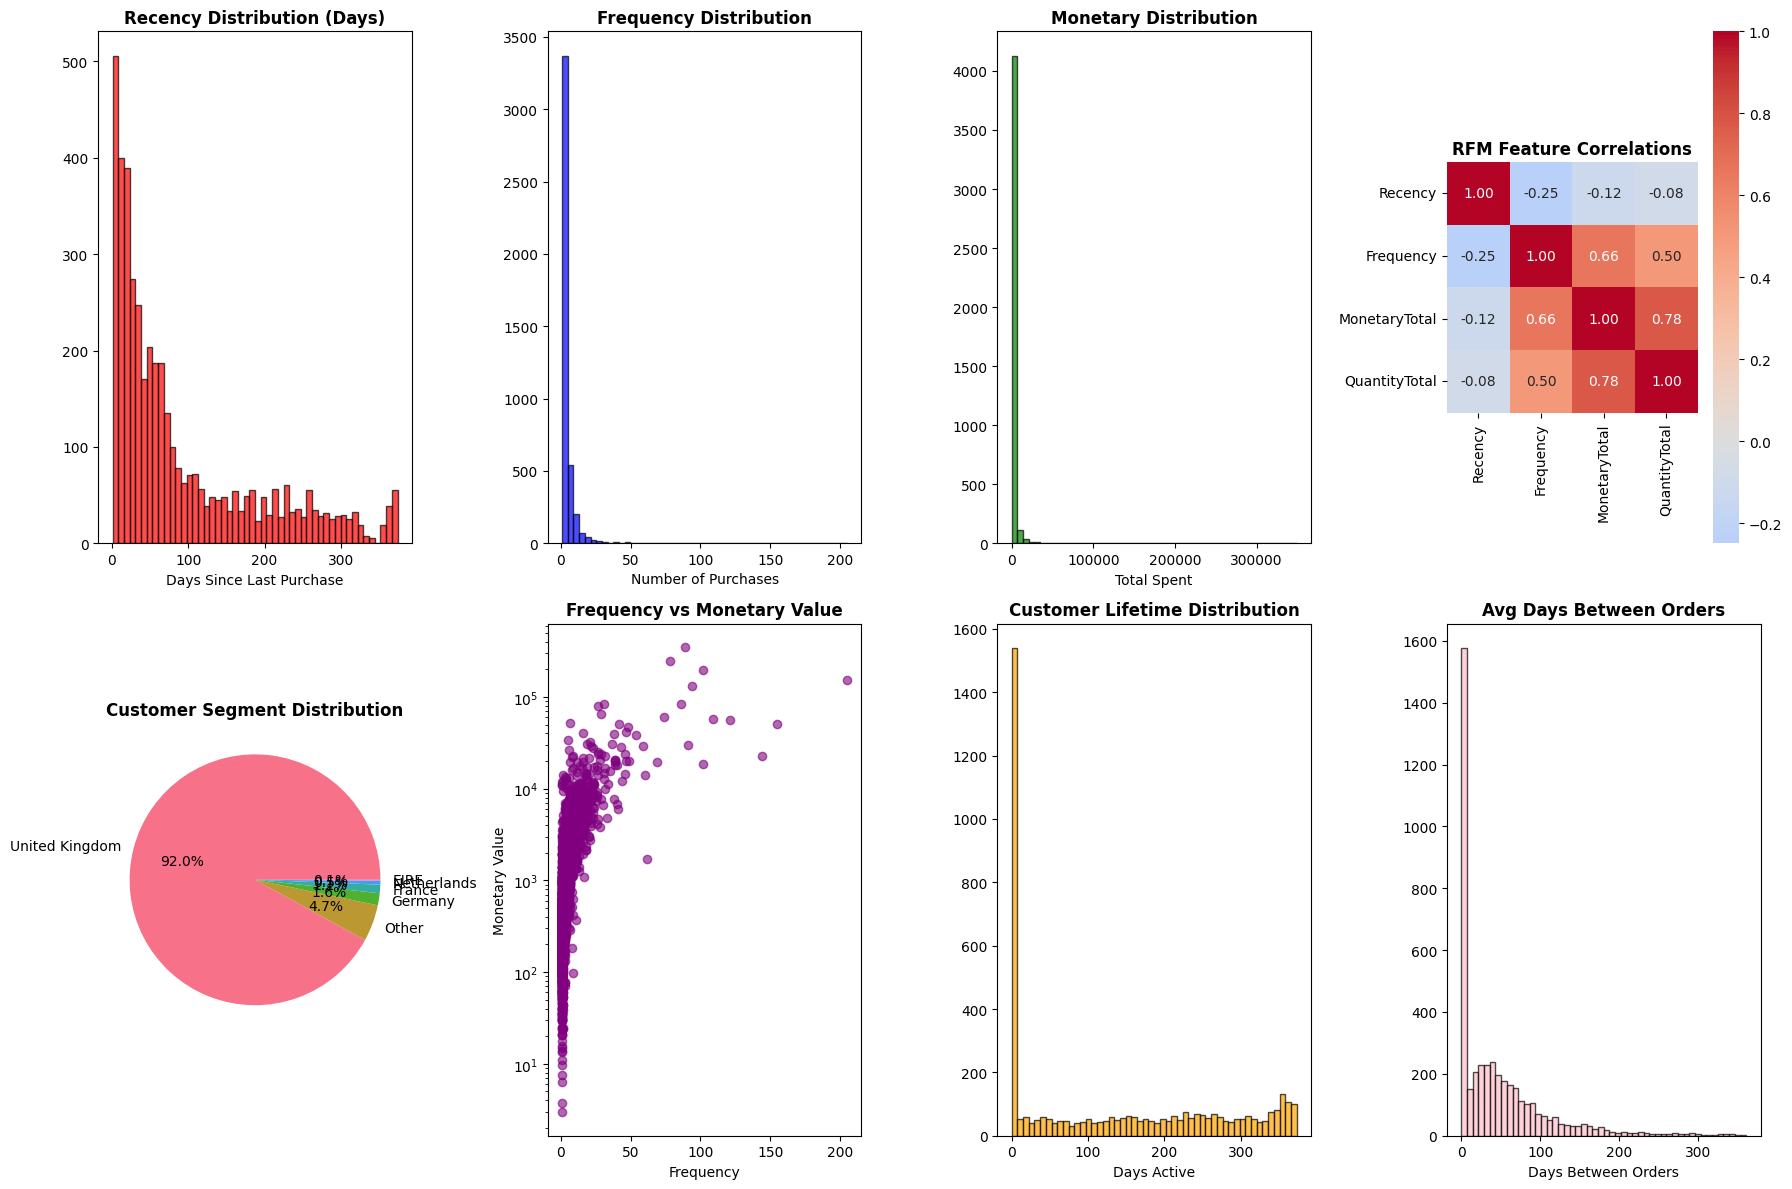

In [16]:
visualize_rfm_analysis(rfm_data)

# 5. MACHINE LEARNING MODELS FOR CLV PREDICTION - FIXED

In [17]:
def train_clv_models(rfm):
    """Train multiple models for CLV prediction - FIXED VERSION"""

    # Prepare features (incorporating demographics and purchase history)
    # FIXED: Only include numeric columns and properly encoded dummy variables
    numeric_cols = ['Recency_log', 'Frequency_log', 'MonetaryMean', 'QuantityMean',
                    'DaysActive', 'AvgDaysBetweenOrders']
    country_cols = [col for col in rfm.columns if col.startswith('Country_')]

    feature_cols = numeric_cols + country_cols

    # Select features and convert boolean country columns to int
    X = rfm[feature_cols].copy() # Create a copy to avoid SettingWithCopyWarning
    for col in country_cols:
        X[col] = X[col].astype(int)

    y = rfm['MonetaryTotal_log']  # Target: Log-transformed total customer value

    # Check for any non-numeric data after conversion
    if not X.select_dtypes(include=[np.number]).shape[1] == X.shape[1]:
        print("WARNING: Non-numeric data detected after conversion!")
        print("Non-numeric columns:", X.select_dtypes(exclude=[np.number]).columns.tolist())
        # Return None or raise an error if non-numeric data still exists
        return None, None, None, None, None, None # Return None for all expected outputs

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features for Linear Regression (NOW FIXED)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train models
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
    }

    results = {}
    predictions = {}

    print("\n" + "="*50)
    print("MODEL PERFORMANCE RESULTS")
    print("="*50)

    for name, model in models.items():
        # Train
        if name == 'Linear Regression':
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        # Evaluate
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        results[name] = {'RMSE': rmse, 'R²': r2}
        predictions[name] = y_pred

        print(f"\n{name}:")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  R²: {r2:.4f}")

    return results, predictions, y_test, models, X_test, feature_cols

# Train models

In [18]:
model_results, model_predictions, y_test, trained_models, X_test, features = train_clv_models(rfm_data)


MODEL PERFORMANCE RESULTS

Linear Regression:
  RMSE: 0.6762
  R²: 0.7276

Random Forest:
  RMSE: 0.6403
  R²: 0.7557


# 6. MODEL COMPARISON AND PREDICTION VISUALIZATIONS

In [19]:
def visualize_model_performance(results, predictions, y_test, trained_models, features):
    """Visualize model performance and predictions"""

    # Check if results, predictions, y_test, trained_models, features are not None
    if results is None or predictions is None or y_test is None or trained_models is None or features is None:
        print("Model training failed. Cannot generate performance visualizations.")
        return

    plt.figure(figsize=(16, 10))

    # Model predictions comparison
    for i, (name, y_pred) in enumerate(predictions.items(), 1):
        plt.subplot(2, 3, i)
        plt.scatter(y_test, y_pred, alpha=0.6, s=30)

        # Perfect prediction line
        min_val = min(min(y_test), min(y_pred))
        max_val = max(max(y_test), max(y_pred))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

        plt.xlabel('Actual CLV (log)')
        plt.ylabel('Predicted CLV (log)')
        plt.title(f'{name}\nR² = {results[name]["R²"]:.3f}', fontweight='bold')
        plt.grid(True, alpha=0.3)

    # Model comparison
    plt.subplot(2, 3, 3)
    model_names = list(results.keys())
    r2_scores = [results[name]['R²'] for name in model_names]

    bars = plt.bar(model_names, r2_scores, color=['skyblue', 'lightgreen'])
    plt.title('Model R² Comparison', fontweight='bold')
    plt.ylabel('R² Score')
    plt.xticks(rotation=45)

    # Add value labels
    for bar, score in zip(bars, r2_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

    # Feature importance (Random Forest)
    plt.subplot(2, 3, 4)
    rf_model = trained_models['Random Forest']
    importance = rf_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': features,
        'importance': importance
    }).sort_values('importance', ascending=True).tail(10)

    plt.barh(feature_importance_df['feature'], feature_importance_df['importance'], color='gold')
    plt.title('Top 10 Feature Importance (Random Forest)', fontweight='bold')
    plt.xlabel('Importance')

    # Residuals plot
    plt.subplot(2, 3, 5)
    best_model_name = max(results.keys(), key=lambda x: results[x]['R²'])
    residuals = y_test - predictions[best_model_name]
    plt.scatter(predictions[best_model_name], residuals, alpha=0.6)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals Plot - {best_model_name}', fontweight='bold')

    # Error distribution
    plt.subplot(2, 3, 6)
    plt.hist(residuals, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
    plt.title('Residuals Distribution', fontweight='bold')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Visualize model performance

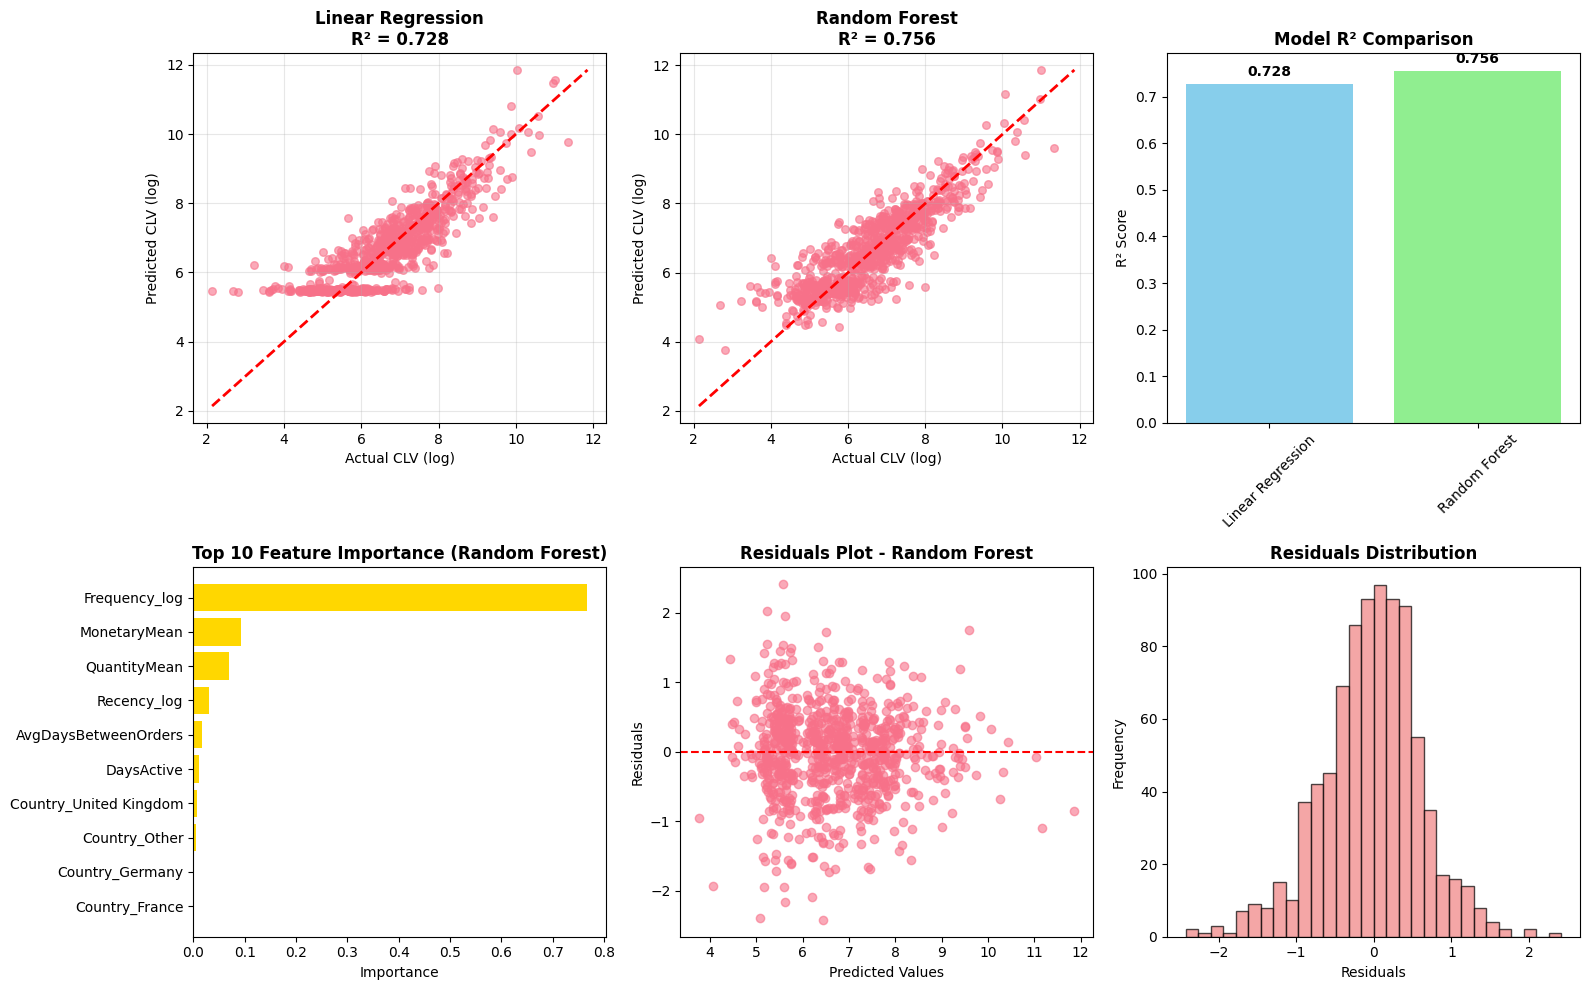

In [20]:
visualize_model_performance(model_results, model_predictions, y_test, trained_models, features)

# 7. BUSINESS INSIGHTS AND CUSTOMER SEGMENTATION

In [21]:
def generate_business_insights(rfm, model_results):
    """Generate actionable business insights"""

    # Check if model_results is not None
    if model_results is None:
        print("Model training failed. Cannot generate business insights.")
        return

    # Customer segmentation based on RFM
    rfm['Customer_Segment'] = 'Low Value'
    rfm.loc[rfm['MonetaryTotal'] > rfm['MonetaryTotal'].quantile(0.75), 'Customer_Segment'] = 'High Value'
    rfm.loc[(rfm['MonetaryTotal'] > rfm['MonetaryTotal'].quantile(0.5)) &
             (rfm['MonetaryTotal'] <= rfm['MonetaryTotal'].quantile(0.75)), 'Customer_Segment'] = 'Medium Value'
    rfm.loc[rfm['MonetaryTotal'] > rfm['MonetaryTotal'].quantile(0.9), 'Customer_Segment'] = 'VIP'

    print("\n" + "="*60)
    print("BUSINESS INSIGHTS & CUSTOMER SEGMENTATION")
    print("="*60)

    print(f"\nTotal Customers: {len(rfm):,}")
    print(f"Average Customer Value: ${rfm['MonetaryTotal'].mean():.2f}")
    print(f"Total Revenue: ${rfm['MonetaryTotal'].sum():,.2f}")

    print(f"\nBest Model: {max(model_results.keys(), key=lambda x: model_results[x]['R²'])}")
    print(f"Best R² Score: {max([results['R²'] for results in model_results.values()]):.3f}")

    print("\nCustomer Segments:")
    for segment in ['VIP', 'High Value', 'Medium Value', 'Low Value']:
        if segment in rfm['Customer_Segment'].values:
            count = rfm[rfm['Customer_Segment'] == segment].shape[0]
            avg_value = rfm[rfm['Customer_Segment'] == segment]['MonetaryTotal'].mean()
            total_value = rfm[rfm['Customer_Segment'] == segment]['MonetaryTotal'].sum()
            print(f"  {segment}: {count:,} customers (${avg_value:.2f} avg, ${total_value:,.0f} total)")

    # Segment visualization
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    segment_counts = rfm['Customer_Segment'].value_counts()
    plt.pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%')
    plt.title('Customer Segment Distribution', fontweight='bold')

    plt.subplot(2, 2, 2)
    sns.boxplot(data=rfm, x='Customer_Segment', y='MonetaryTotal')
    plt.title('Monetary Value by Segment', fontweight='bold')
    plt.yscale('log')
    plt.xticks(rotation=45)

    plt.subplot(2, 2, 3)
    sns.boxplot(data=rfm, x='Customer_Segment', y='Frequency')
    plt.title('Purchase Frequency by Segment', fontweight='bold')
    plt.xticks(rotation=45)

    plt.subplot(2, 2, 4)
    sns.boxplot(data=rfm, x='Customer_Segment', y='Recency')
    plt.title('Recency by Segment', fontweight='bold')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Generate business insights


BUSINESS INSIGHTS & CUSTOMER SEGMENTATION

Total Customers: 4,312
Average Customer Value: $2048.24
Total Revenue: $8,832,003.27

Best Model: Random Forest
Best R² Score: 0.756

Customer Segments:
  VIP: 432 customers ($12240.74 avg, $5,288,001 total)
  High Value: 646 customers ($2503.70 avg, $1,617,392 total)
  Medium Value: 1,078 customers ($1132.30 avg, $1,220,623 total)
  Low Value: 2,156 customers ($327.45 avg, $705,987 total)


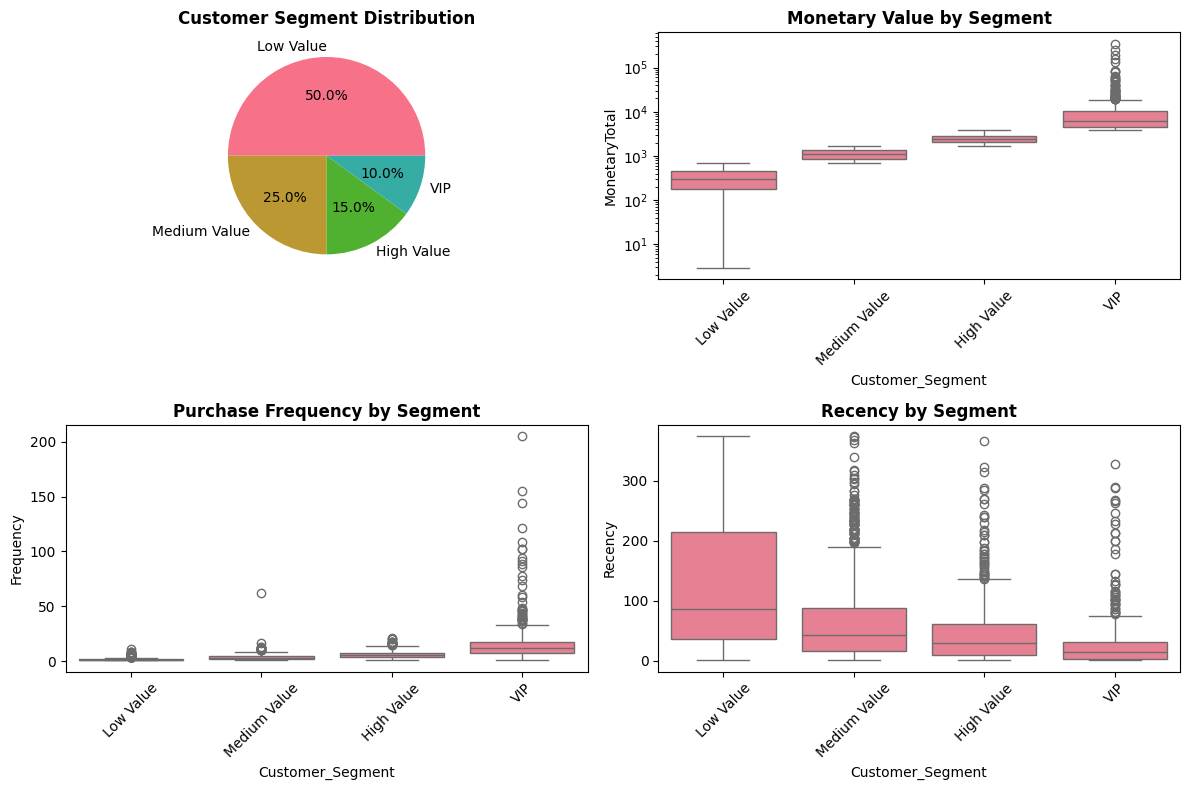

In [22]:
generate_business_insights(rfm_data, model_results)